# Unit 8 Code: Nonparametric Regression and Generalized Additive Models

## Problem #1

#### (a) Load the exa and exb datasets into R. Plot $y$ as a function of $x$. Would a linear parametric model do well in explanation/prediction for either of these datasets?

x,y,m
0.0048,-0.0339,0
0.0086,0.1654,0
0.0117,0.0245,0
0.0170,0.1784,0
0.0261,-0.3466,0
0.0299,-0.7550,0


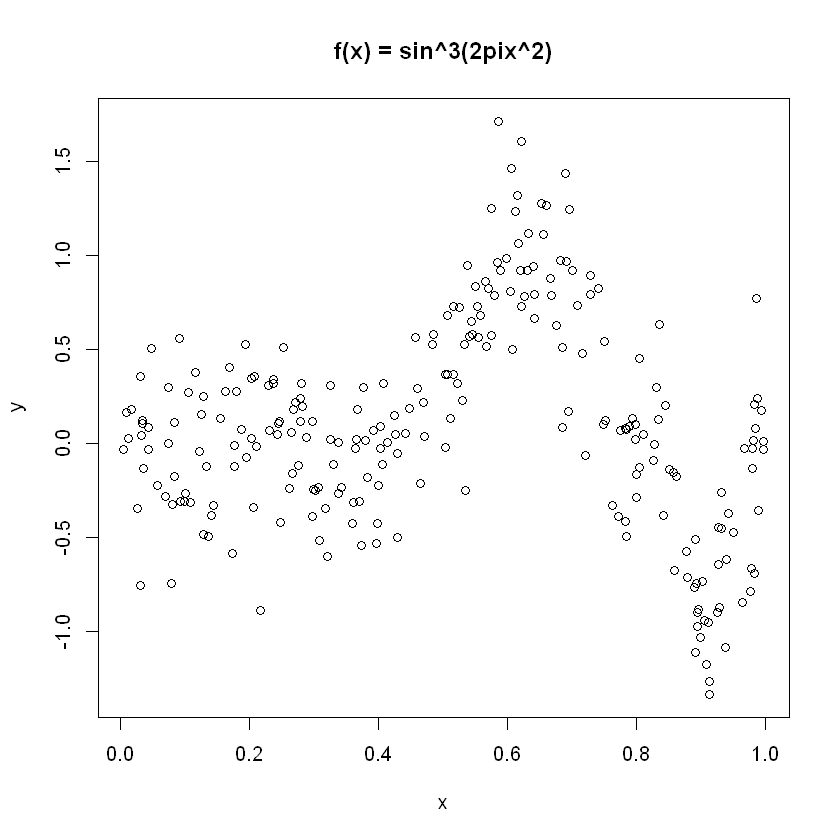

In [4]:
library(faraway)
data(exa)
head(exa)

plot(y ~ x, data = exa, main = "f(x) = sin^3(2pix^2)")

A linear model would not do well with this model because of the curvature of the data. It would not be able to accurately model the data with a straight line.

#### (b) Use the values in the variable $m$ to add a smooth function over the $x, y$ data. 

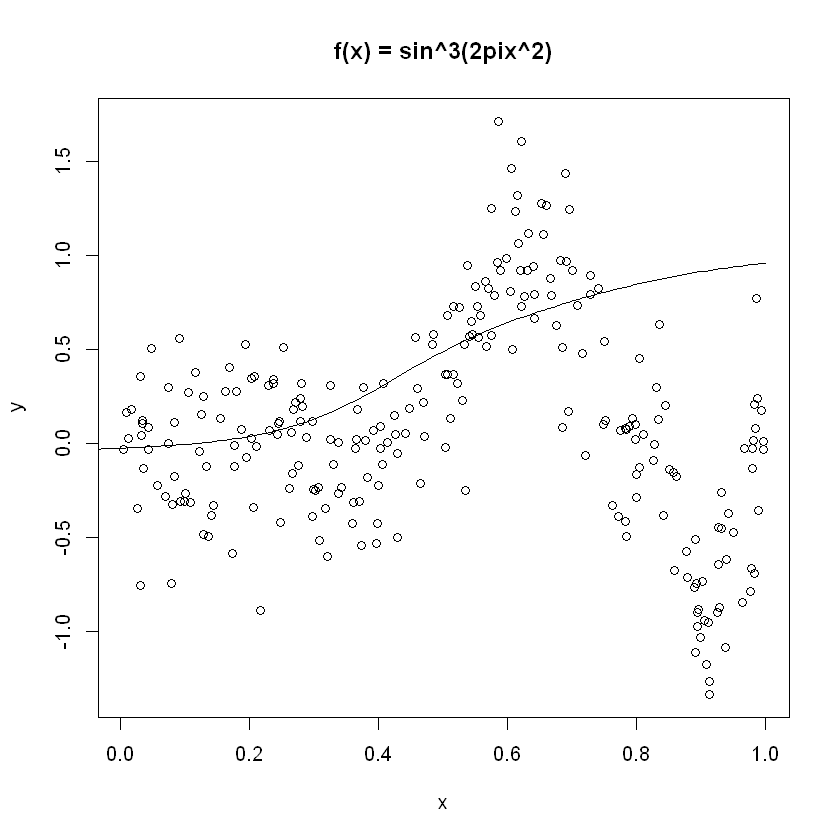

In [5]:
plot(y ~ x, data = exa, main = "f(x) = sin^3(2pix^2)")
lines(ksmooth(exa$m, exa$y, "normal", 0.5))

#### (c) Use the ksmooth() function to plot some kernel estimators of the unknown function $Y = f(x)$. Explore different possibilities for kernel functions (e.g., box/uniform, Gaussian/normal), and different bandwidths. Which combination gives the best fit?

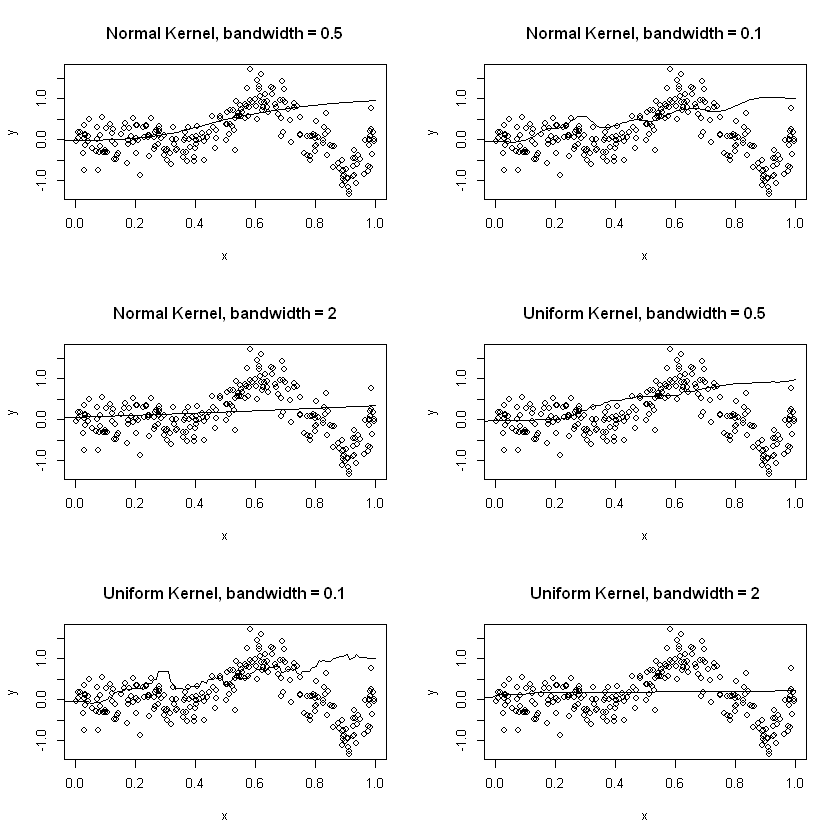

In [19]:
par(mfrow = c(3,2))
plot(y ~ x, data = exa, main = "Normal Kernel, bandwidth = 0.5")
lines(ksmooth(exa$m, exa$y, kernel = "normal", 0.5))
plot(y ~ x, data = exa, main = "Normal Kernel, bandwidth = 0.1")
lines(ksmooth(exa$m, exa$y, kernel = "normal", 0.1))
plot(y ~ x, data = exa, main = "Normal Kernel, bandwidth = 2")
lines(ksmooth(exa$m, exa$y, "normal", 2))
plot(y ~ x, data = exa, main = "Uniform Kernel, bandwidth = 0.5")
lines(ksmooth(exa$m, exa$y, "box", 0.5))
plot(y ~ x, data = exa, main = "Uniform Kernel, bandwidth = 0.1")
lines(ksmooth(exa$m, exa$y, "box", 0.1))
plot(y ~ x, data = exa, main = "Uniform Kernel, bandwidth = 2")
lines(ksmooth(exa$m, exa$y, "box", 2))

## Problem #2

Using the datasets from above, construct a smoothing spline and regression spline estimator of $f(x)$. 

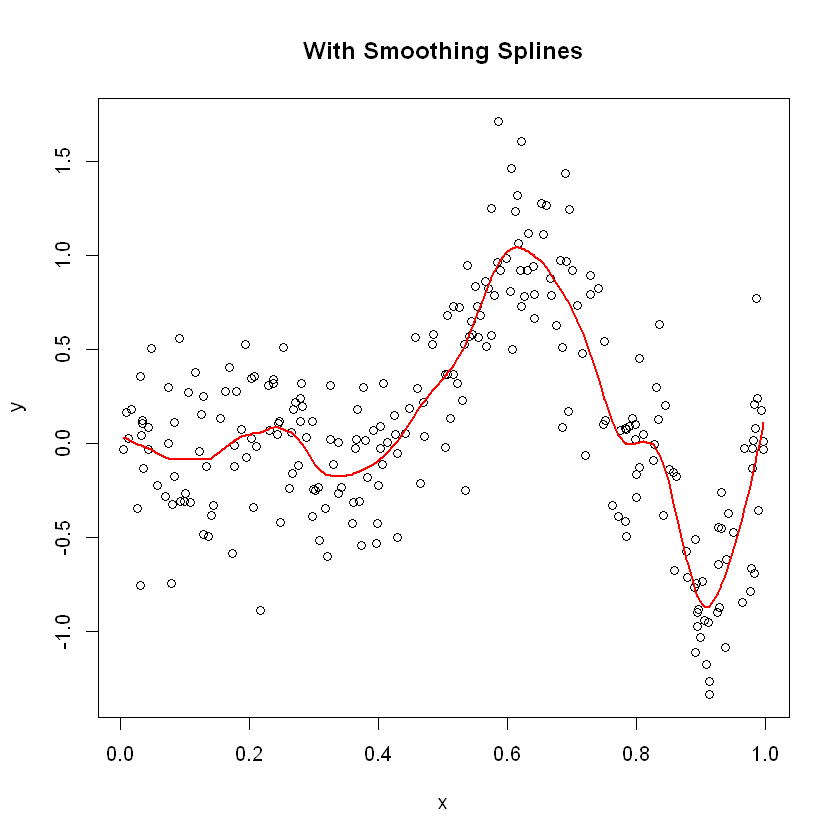

In [28]:
fit1 = with(exa, smooth.spline(y = y, x = x))

plot(y ~ x, data = exa, main = "With Smoothing Splines")
lines(fit1, col = "red", lwd = 2)

## Problem #3: GAMs with Simulated Data

In this example, we show how to check the validity of a GAM (using the gam() function in R), through simulated data. This allows us to try and understand the intricacies of gam() without having to worry about the context of the data. Can we adapt this to our model, to generate a synthetic response/death count given the real predictors?

First, we construct three predictor variables. The goal here is to construct a GAM with different types of predictor terms (e.g., factors, continuous variables, some that will enter linearly/parametrically, some that enter transformed).

1. x1: A continuous predictor that, we will suppose has a nonlinear relationship with the response.
2. x2: A categorical variable that takes values in $\{s, m, t\}$.
3. x3: A categorical variable with two levels.

In [1]:
library(ggplot2)
set.seed(12)

#construct predictors 
n = 100
d <- data.frame(
   x1=rnorm(n, mean = 45, sd = 15),
   x2=sample(c('s','m','t'),size=n,replace=TRUE),
   x3=sample(c(F,T),size=n,replace=TRUE),
 stringsAsFactors=F)
#log(d$x1^2)

Then, we make the response some nonlinear/nonparametric function of x1. In a realworld situation, we wouldn't know this functional relationship and would estimate it. Other terms are modeled parametrically. The response has normal noise.

The model here is a Poisson GAM, with true relationship $$\log(\mu_i) = \beta_1 + log(0.5x_1^2) - x_2 + x_3.$$
Note that 

1. the construction of $\mu$ has the linear predictor exponentiated, because of the nature of the link function. 
2. We use $\mu$ to construct $y$. The assumption for Poisson regression is that $Y_i$ is Poisson with mean $\mu_i$. 
3. as.integer(as.factor(VARIABLE)) converts the labels of VARIABLE to 1, 2, 3,.. so that we can construct the relationship for these factors.

[1]   95.54783 2356.92904 1276.71031  179.05338   15.29710 2275.31469

[1]   66 2358 1240  166   21 2300

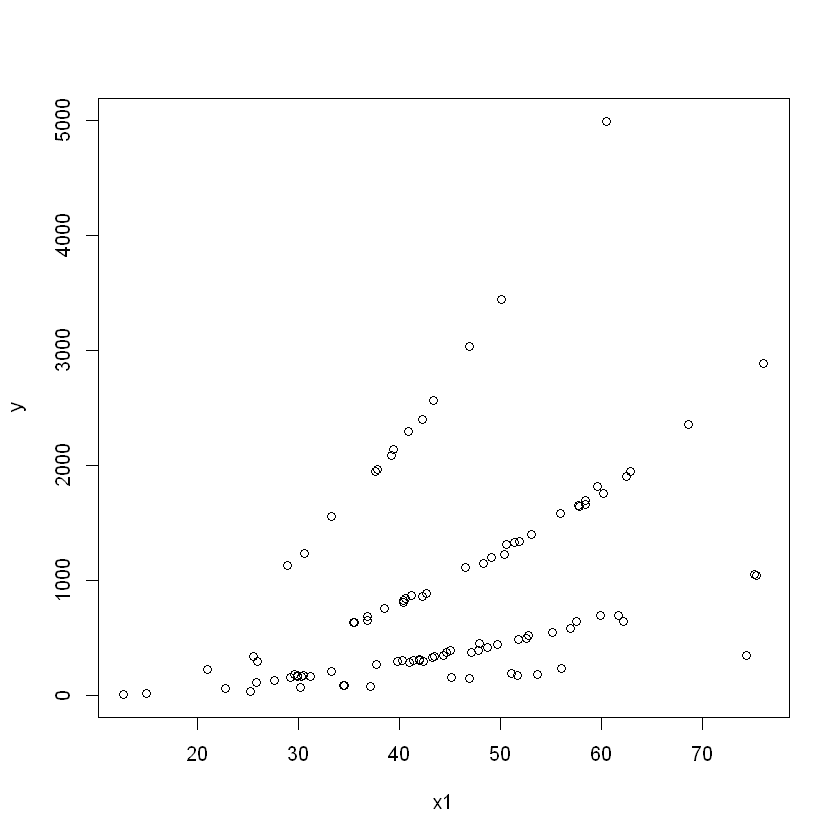

In [2]:
#construct response
d$mu = with(d, exp(log(0.5*x1^2) - as.integer(as.factor(x2)) + as.integer(as.factor(x3))))

d$y = rpois(n, d$mu); #head(d$y)
with(d, plot(x1, y))

head(d$mu) #simulated mean values
head(d$y)  #simulated response values


Let's run a generalized linear model and show why this model doesn't fit all that well. The fit will be distorted by the log relationship with $x_1$. Then we'll fit a GAM.

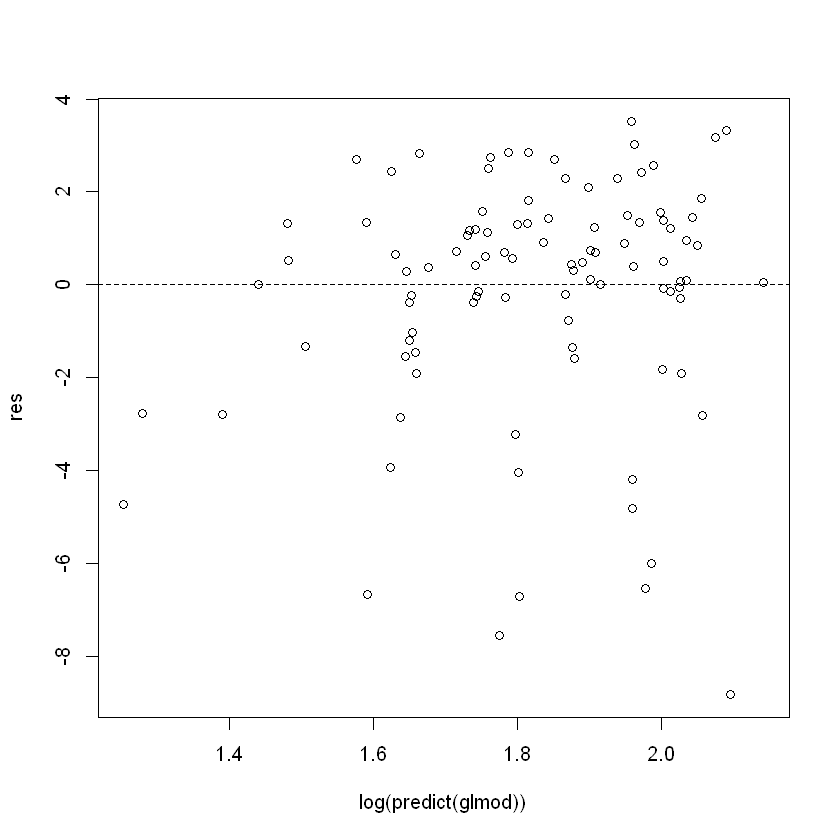

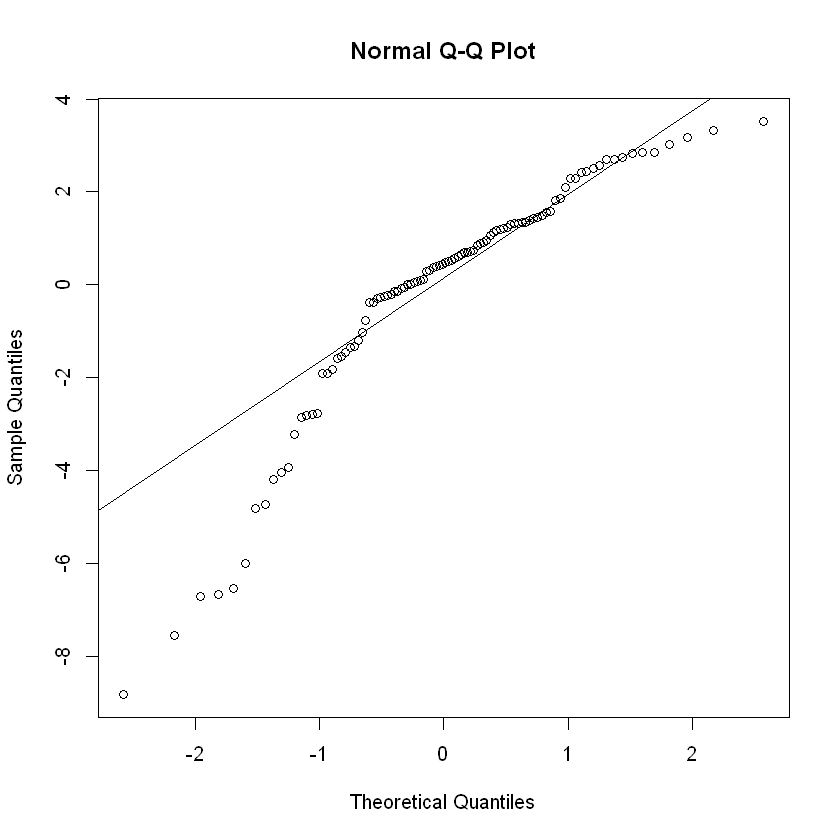

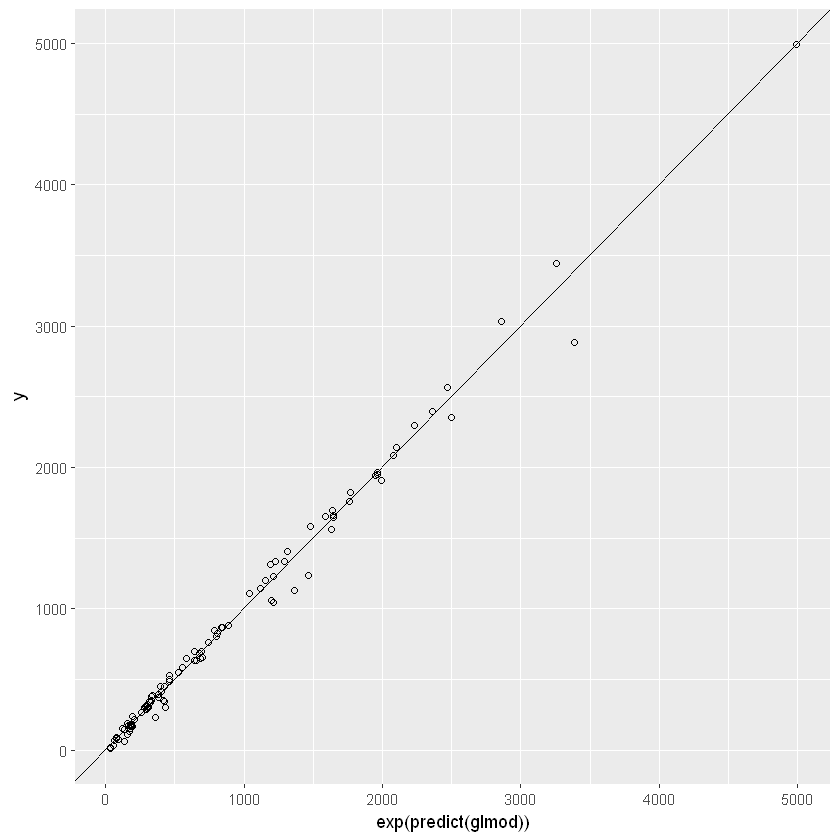

In [3]:
glmod = glm(y ~ x1 + as.integer(as.factor(x2)) + as.integer(as.factor(x3)), d, family = poisson)

res <- residuals(glmod, type="deviance") #compute the deviance residuals

#residual plot
plot(log(predict(glmod)), res)
abline(h=0, lty=2)
qqnorm(res)
qqline(res)

#fitted vs actual
ggplot(d,aes(exp(predict(glmod)),y)) + geom_point(shape=1) + geom_abline(slope=1)



Notice above that the residual plots aren't horrible, but there's some skew. And, the QQ plot doesn't look good. We'll also see that the prediction error is higher than using a GAM.

If we fit the model with using the known relationship, we get a better fit. See below. Of course we can't ever do that in practice (without good theory) or through guessing. 

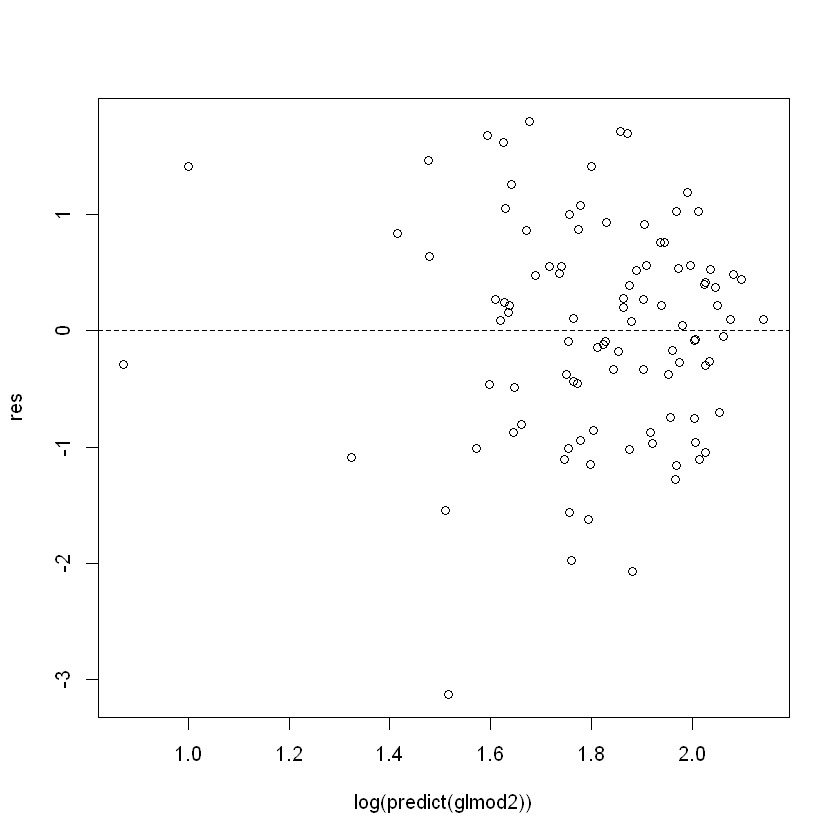

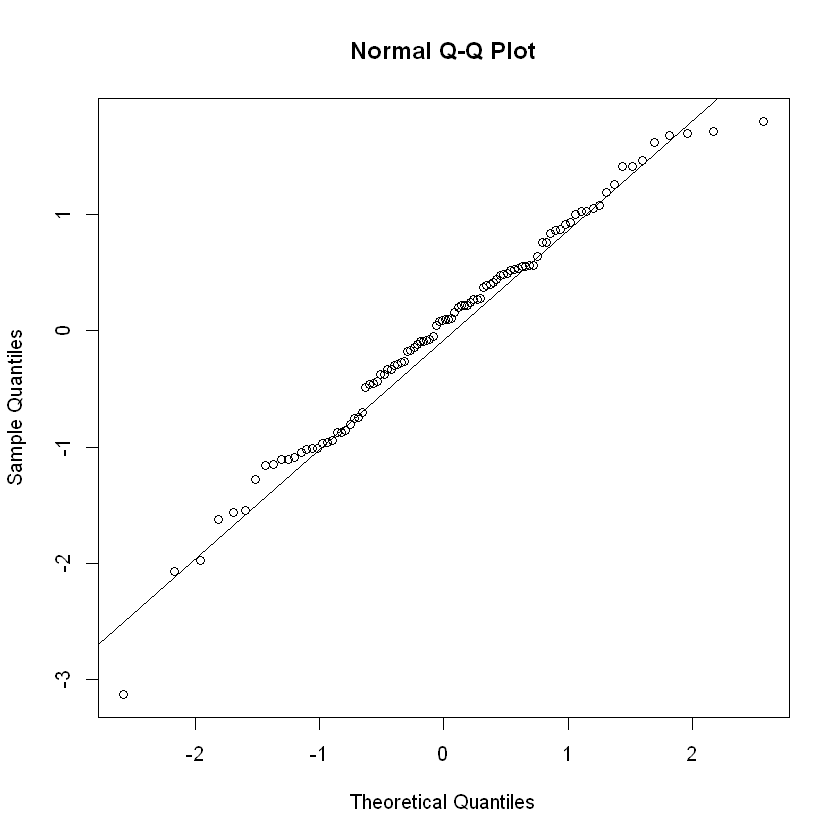

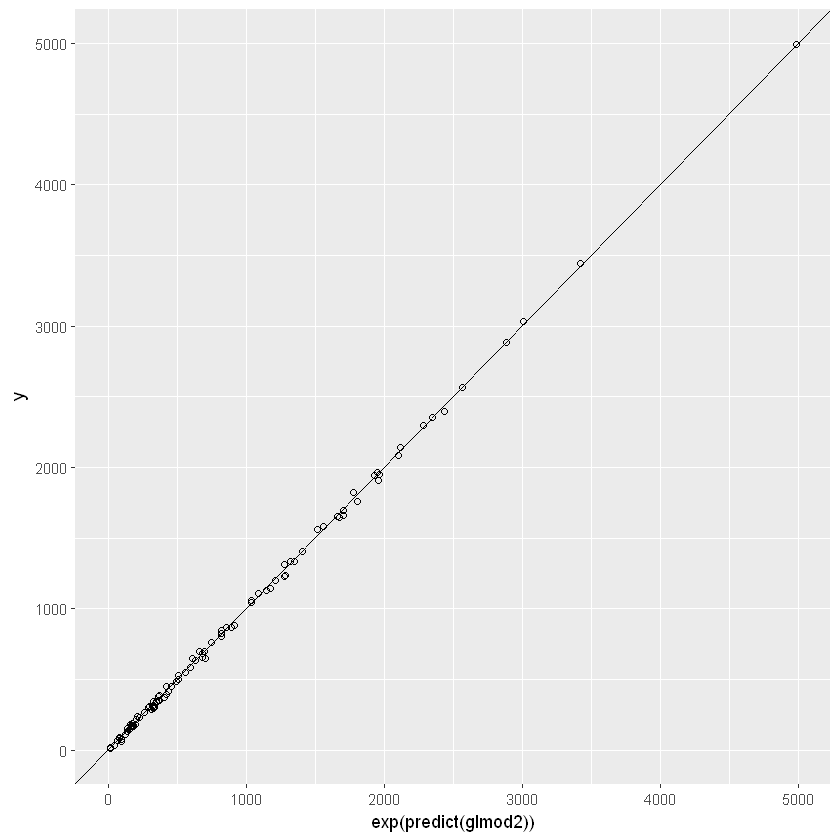

In [4]:
glmod2 = glm(y ~ log(0.5*x1^2) + as.integer(as.factor(x2)) + as.integer(as.factor(x3)), d, family = poisson)
pred_error = sum((exp(predict(glmod2))-d$y)^2); #pred_error

#par(mfrow = c(2,2)); #plot(mod2)
res <- residuals(glmod2, type="deviance") #compute the deviance residuals
#plot(y~log(0.005*x1^2), data=d) 
#predicted = predict(glmod2)
#plot(predicted, d$y)

#residual plot
plot(log(predict(glmod2)), res)
abline(h=0, lty=2)
qqnorm(res)
qqline(res)

#fitted vs actual
ggplot(d,aes(exp(predict(glmod2)),y)) + geom_point(shape=1) + geom_abline(slope=1)

So, when we don't know the true relationship, we try to estimate it using GAMs.

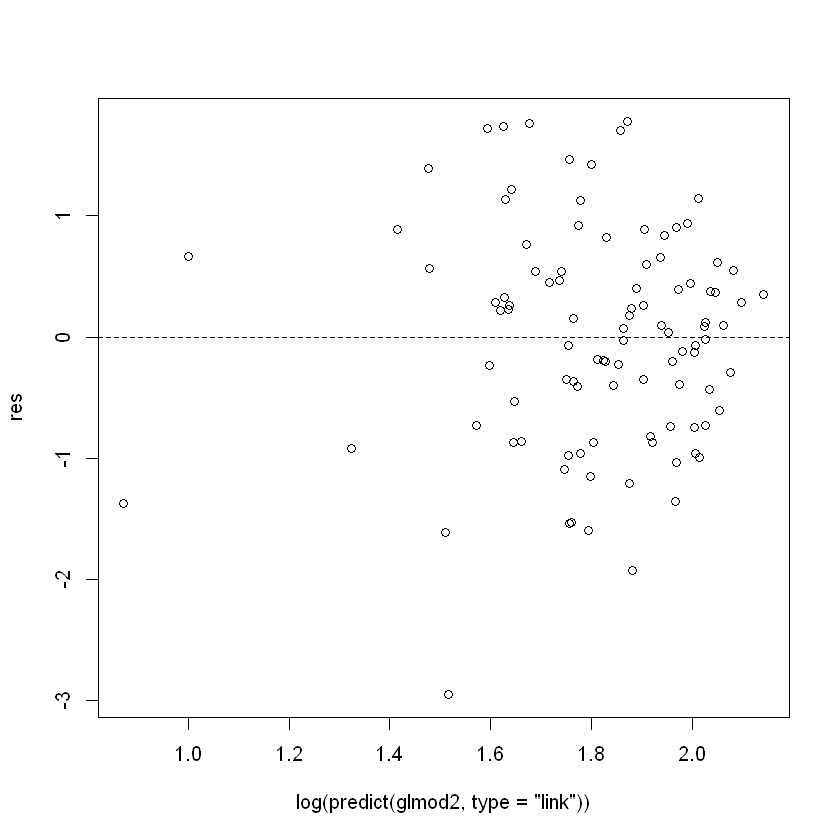

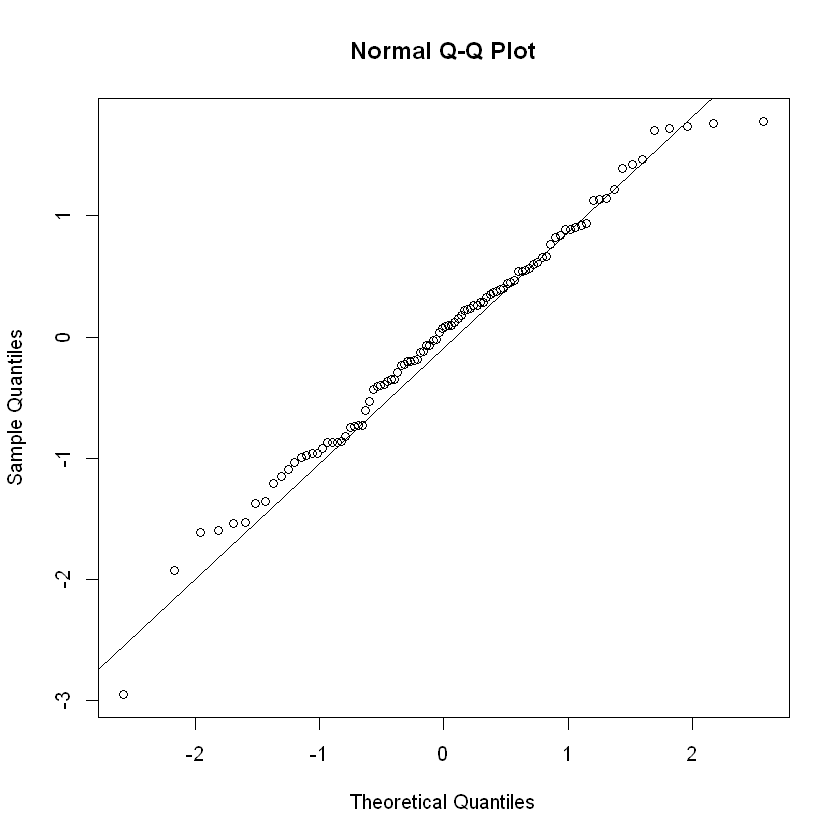

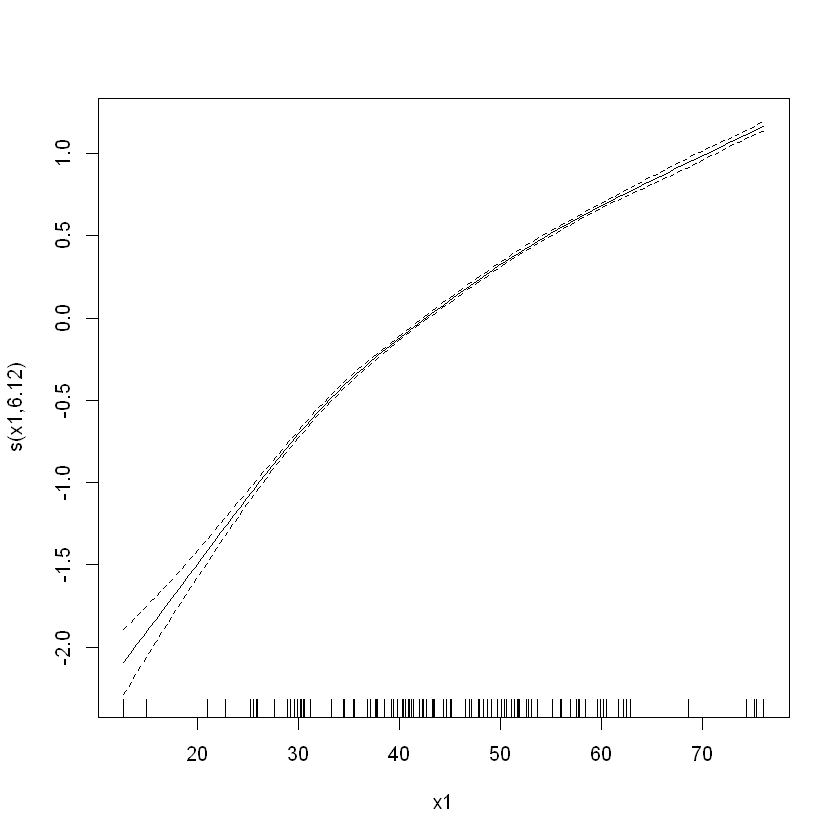

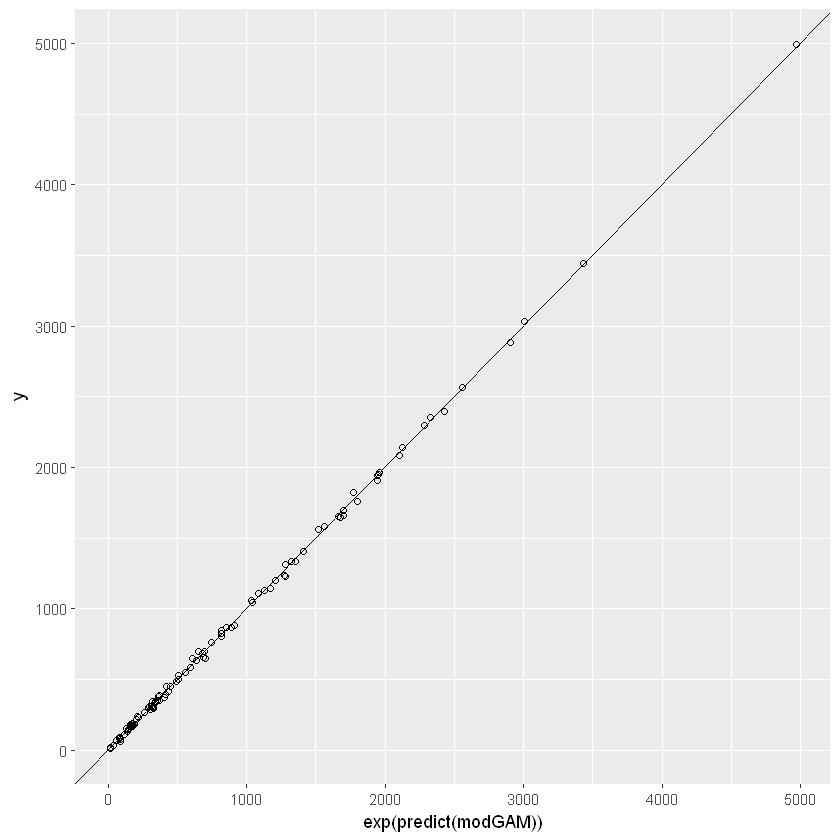

In [8]:
library(mgcv)
modGAM <- gam(y ~ s(x1) + as.integer(as.factor(x2)) + as.integer(as.factor(x3)), data=d, family = poisson)

res <- residuals(modGAM, type="deviance") #compute the deviance residuals

#residual and QQ plot
plot(log(predict(glmod2, type = "link")), res)
abline(h=0, lty=2)
qqnorm(res)
qqline(res)
plot(modGAM) 

#fitted vs actual
ggplot(d,aes(exp(predict(modGAM)),y)) + geom_point(shape=1) + geom_abline(slope=1)



Method: UBRE   Optimizer: outer newton
full convergence after 6 iterations.
Gradient range [1.684616e-10,1.684616e-10]
(score -0.007220951 & scale 1).
Hessian positive definite, eigenvalue range [0.0234574,0.0234574].
Model rank =  12 / 12 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

        k'  edf k-index p-value  
s(x1) 9.00 6.12    0.85   0.065 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Family: poisson 
Link function: log 

Formula:
y ~ s(x1) + as.integer(as.factor(x2)) + as.integer(as.factor(x3))

Parametric coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                6.816974   0.014878   458.2   <2e-16 ***
as.integer(as.factor(x2)) -1.005862   0.005568  -180.6   <2e-16 ***
as.integer(as.factor(x3))  1.000533   0.007337   136.4   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
        edf Ref.df Chi.sq p-value    
s(x1) 6.124   7.22  19608  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.999   Deviance explained = 99.9%
UBRE = -0.007221  Scale est. = 1         n = 100

[1] 42871.74

[1] 46072.4

[1] 683376.6

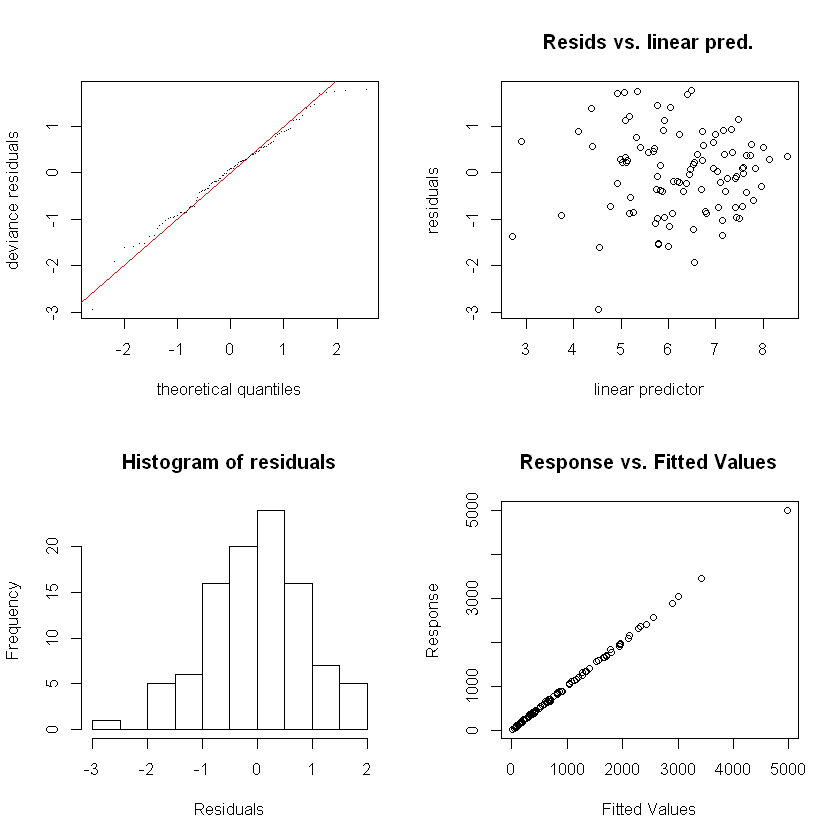

In [6]:
gam.check(modGAM)
summary(modGAM)
pred_errorGAM = sum((exp(predict(modGAM))-d$y)^2); pred_errorGAM
pred_errorGLMKnown = sum((exp(predict(glmod2))-d$y)^2); pred_errorGLMKnown
pred_errorGLM = sum((exp(predict(glmod)) - d$y)^2); pred_errorGLM


Let's look at predictions

In [9]:
set.seed(1101)
n = 10
d_predict <- data.frame(
   x1=rnorm(n, mean = 45, sd = 15),
   x2=sample(c('s'),size=n,replace=TRUE),
   x3=sample(c(F),size=n,replace=TRUE),
 stringsAsFactors=F)
d_predict
true_mu = with(d_predict, exp(log(0.5*x1^2) - as.integer(as.factor(x2)) + as.integer(as.factor(x3))))
p = predict(modGAM, d_predict, type = "terms"); head(exp(p))


x1,x2,x3
30.636544,s,FALSE
41.629958,s,FALSE
31.936419,s,FALSE
4.300102,s,FALSE
58.475732,s,FALSE
55.629185,s,FALSE
42.319362,s,FALSE
46.804460,s,FALSE
36.204465,s,FALSE
36.789660,s,FALSE


as.integer(as.factor(x2)),as.integer(as.factor(x3)),s(x1)
0.3657294,2.71973,0.51630245
0.3657294,2.71973,0.95513265
0.3657294,2.71973,0.56413045
0.3657294,2.71973,0.06158512
0.3657294,2.71973,1.88479489
0.3657294,2.71973,1.71194385


In [10]:
ppp = predict(modGAM, d_predict, type = "terms", se.fit=T); 
lower<-ppp$fit-1.96*ppp$se.fit; exp(head(lower[,3]))
upper<-ppp$fit+1.96*ppp$se.fit; exp(head(upper[,3]))
lcl<-exp(lower[,2]);
ucl<-exp(upper[,2])

head(log(predict(modGAM, d_predict, type = "link")))

1          2          3          4          5          6 
0.50547806 0.94265038 0.55291007 0.04308416 1.85811469 1.68550750

1          2          3          4          5          6 
0.52735864 0.96778021 0.57557853 0.08803066 1.91185818 1.73879484

1        2        3        4        5        6 
1.816547 1.911872 1.830848 1.392353 2.007605 1.994602

## Problem #3

The fat dataset gives percentage of body fat, age, weight, height, and 10 body circumference measurements for 252 men. Body fat is estimated through an underwater weighing technique, but this is inconvenient to use widely. Develop an additive model that allows the estimation of body fat for men using only a scale and measuring tape. Your model should predict % body fat according to the variable siri. You may not use Brozek's % body fat, density or fat free weight as predictors.

In [11]:
library(faraway)
library(mgcv)
data(fat)
head(fat)


brozek,siri,density,age,weight,height,adipos,free,neck,chest,abdom,hip,thigh,knee,ankle,biceps,forearm,wrist
12.6,12.3,1.0708,23,154.25,67.75,23.7,134.9,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
6.9,6.1,1.0853,22,173.25,72.25,23.4,161.3,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
24.6,25.3,1.0414,22,154.00,66.25,24.7,116.0,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
10.9,10.4,1.0751,26,184.75,72.25,24.9,164.7,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
27.8,28.7,1.0340,24,184.25,71.25,25.6,133.1,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7
20.6,20.9,1.0502,24,210.25,74.75,26.5,167.0,39.0,104.5,94.4,107.8,66.0,42.0,25.6,35.7,30.6,18.8


In [32]:
newFat = fat[ , -c(1, 3, 8)]
head(newFat)

siri,age,weight,height,adipos,neck,chest,abdom,hip,thigh,knee,ankle,biceps,forearm,wrist
12.3,23,154.25,67.75,23.7,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
6.1,22,173.25,72.25,23.4,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
25.3,22,154.00,66.25,24.7,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
10.4,26,184.75,72.25,24.9,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
28.7,24,184.25,71.25,25.6,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7
20.9,24,210.25,74.75,26.5,39.0,104.5,94.4,107.8,66.0,42.0,25.6,35.7,30.6,18.8



Family: poisson 
Link function: log 

Formula:
as.integer(siri) ~ age + adipos + neck + s(abdom) + s(hip) + 
    s(thigh) + s(wrist)

Parametric coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  3.234451   0.493492   6.554 5.59e-11 ***
age          0.004795   0.001653   2.901  0.00371 ** 
adipos       0.024572   0.012645   1.943  0.05199 .  
neck        -0.032435   0.011577  -2.802  0.00508 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
           edf Ref.df  Chi.sq  p-value    
s(abdom) 3.678  4.604 115.884  < 2e-16 ***
s(hip)   1.000  1.000   5.463  0.01943 *  
s(thigh) 5.357  6.421  19.099  0.00555 ** 
s(wrist) 2.395  3.053  23.460 3.46e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.754   Deviance explained =   74%
UBRE = 0.18972  Scale est. = 1         n = 252

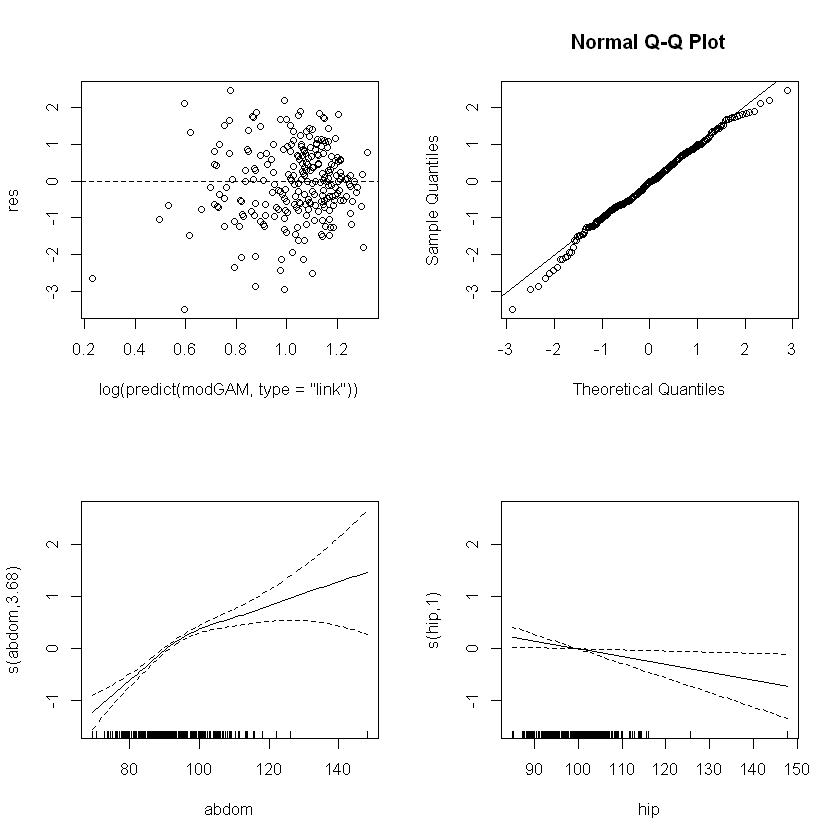

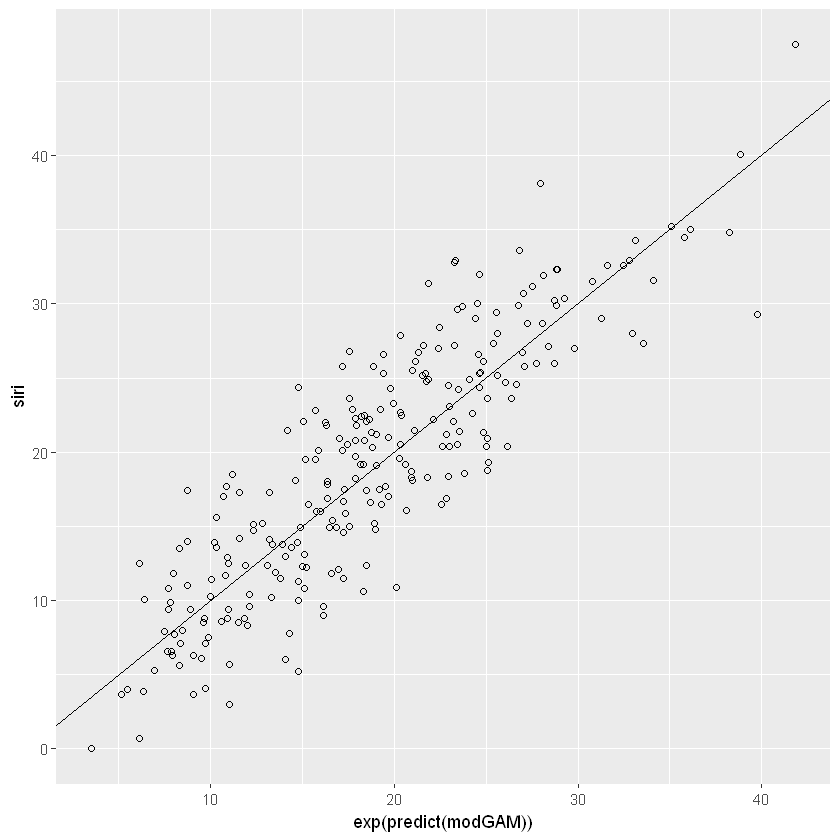

In [80]:
library(mgcv)
library(ggplot2)
# modGAM <- gam(y ~ s(x1) + as.integer(as.factor(x2)) + as.integer(as.factor(x3)), data=d, family = poisson)
# modGAM = gam(as.integer(siri) ~ age + weight + height + adipos + neck + chest + abdom + hip + thigh + knee + ankle + biceps + forearm + wrist, data = newFat, family = poisson)
modGAM = gam(as.integer(siri) ~ age + adipos + neck + s(abdom) + s(hip) + s(thigh) + s(wrist), data = newFat, family = poisson)


res <- residuals(modGAM, type="deviance") #compute the deviance residuals

summary(modGAM)

#residual and QQ plot
par(mfrow = c(2,2))
plot(log(predict(modGAM, type = "link")), res)
abline(h=0, lty=2)
qqnorm(res)
qqline(res)
plot(modGAM) 

#fitted vs actual
ggplot(newFat, aes(exp(predict(modGAM)), siri)) + geom_point(shape=1) + geom_abline(slope=1)